In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR


In [93]:
def DoKFold(model,X,y,k,random_state=146,scaler=None):
    '''Function will perform K-fold validation and return a list of K training and testing scores, inclduing R^2 as well as MSE.
    
        Inputs:
            model: An sklearn model with defined 'fit' and 'score' methods
            X: An N by p array containing the features of the model.  The N rows are observations, and the p columns are features.
            y: An array of length N containing the target of the model
            k: The number of folds to split the data into for K-fold validation
            random_state: used when splitting the data into the K folds (default=146)
            scaler: An sklearn feature scaler.  If none is passed, no feature scaling will be performed
        Outputs:
            train_scores: A list of length K containing the training scores
            test_scores: A list of length K containing the testing scores
            train_mse: A list of length K containing the MSE on training data
            test_mse: A list of length K containing the MSE on testing data
    '''
    
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k,shuffle=True,random_state=random_state)
    
    train_scores=[]
    test_scores=[]
    train_mse=[]
    test_mse=[]
    
    for idxTrain, idxTest in kf.split(X):
        Xtrain = X[idxTrain,:]
        Xtest = X[idxTest,:]
        ytrain = y[idxTrain]
        ytest = y[idxTest]
        
        if scaler != None:
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)
        
        model.fit(Xtrain,ytrain)
        
        train_scores.append(model.score(Xtrain,ytrain))
        test_scores.append(model.score(Xtest,ytest))
        
        # Compute the mean squared errors
        ytrain_pred = model.predict(Xtrain)
        ytest_pred = model.predict(Xtest)
        train_mse.append(np.mean((ytrain-ytrain_pred)**2))
        test_mse.append(np.mean((ytest-ytest_pred)**2))
        
    return train_scores,test_scores,train_mse,test_mse

def CompareClasses(actual, predicted, names=None):
    '''Function returns a confusion matrix, and overall accuracy given:
            Input:  actual - a list of actual classifications
                    predicted - a list of predicted classifications
                    names (optional) - a list of class names
    '''
    import pandas as pd
    accuracy = sum(actual==predicted)/actual.shape[0]
    classes = pd.DataFrame(columns=['Actual','Predicted'])
    classes['Actual'] = actual
    classes['Predicted'] = predicted
    conf_mat = pd.crosstab(classes['Predicted'],classes['Actual'])
    # Relabel the rows/columns if names was provided
    if type(names) != type(None):
        conf_mat.index=y_names
        conf_mat.index.name='Predicted'
        conf_mat.columns=y_names
        conf_mat.columns.name = 'Actual'
    print('Accuracy = ' + format(accuracy, '.2f'))
    return conf_mat, accuracy

def GetColors(N, map_name='rainbow'):
    '''Function returns a list of N colors from a matplotlib colormap
            Input: N = number of colors, and map_name = name of a matplotlib colormap
    
            For a list of available colormaps: 
                https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    '''
    import matplotlib
    cmap = matplotlib.cm.get_cmap(name=map_name)
    n = np.linspace(0,N,N)/N
    colors = cmap(n)
    return colors

def PlotGroups(points, groups, colors, ec='black', ax='None'):
    '''Function makes a scatter plot, given:
            Input:  points (array)
                    groups (an integer label for each point)
                    colors (one rgb tuple for each group)
                    ec (edgecolor for markers, default is black)
                    ax (optional handle to an existing axes object to add the new plot on top of)
            Output: handles to the figure (fig) and axes (ax) objects
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create a new plot, unless something was passed for 'ax'
    if ax == 'None':
        fig,ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    for i in np.unique(groups):
        idx = (groups==i)
        ax.scatter(points[idx,0], points[idx,1],color=colors[i],
                    ec=ec,alpha=0.5,label = 'Group ' + str(i))
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    return fig, ax

In [44]:
df = pd.read_csv('./data/lbr_persons.csv')

In [45]:
df.head()

,Unnamed: 0,location,size,wealth,gender,age,education
0,1,6,11,1,1,54,2
1,2,6,3,4,1,37,3
2,3,6,10,4,2,50,0
3,4,6,1,3,1,32,2
4,5,6,7,3,1,36,0


In [46]:
df = df.set_index('Unnamed: 0')

In [47]:
df.head()
print(df.shape)

(48219, 6)


In [48]:
#seperate X and y variables
X = df.copy().drop('education', axis = 1)
y = df.copy()['education']

In [172]:
y.mean()

0.6653393890375163

In [173]:
y.median()

0.0

In [179]:
print(y.unique())

[2 3 0 1 9 8]


# Look at the Data

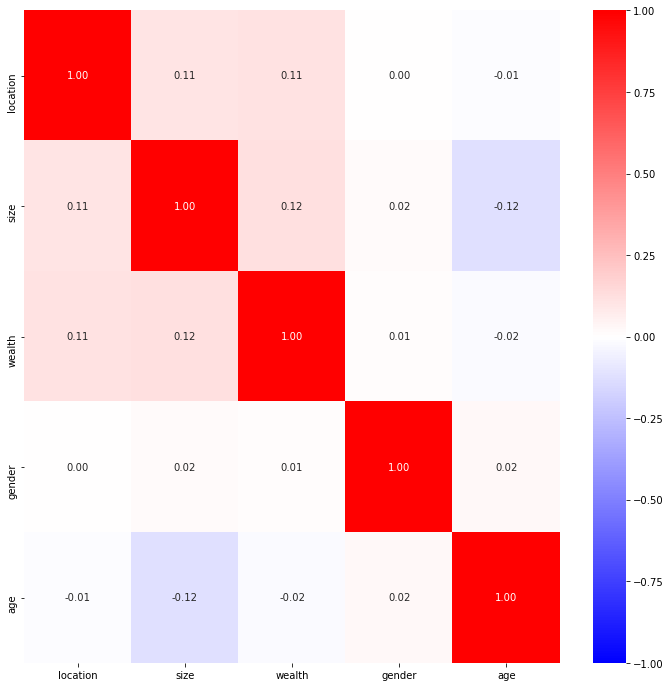

In [191]:
#Look at a heat map of the X data
import seaborn as sns
plt.figure(figsize=(12,12))

sns.heatmap(X.corr(), xticklabels=X.columns,yticklabels=X.columns,vmin=-1,vmax=1,cmap='bwr',annot=True,fmt='.2f')
plt.savefig('corr_heat.png')
plt.show()

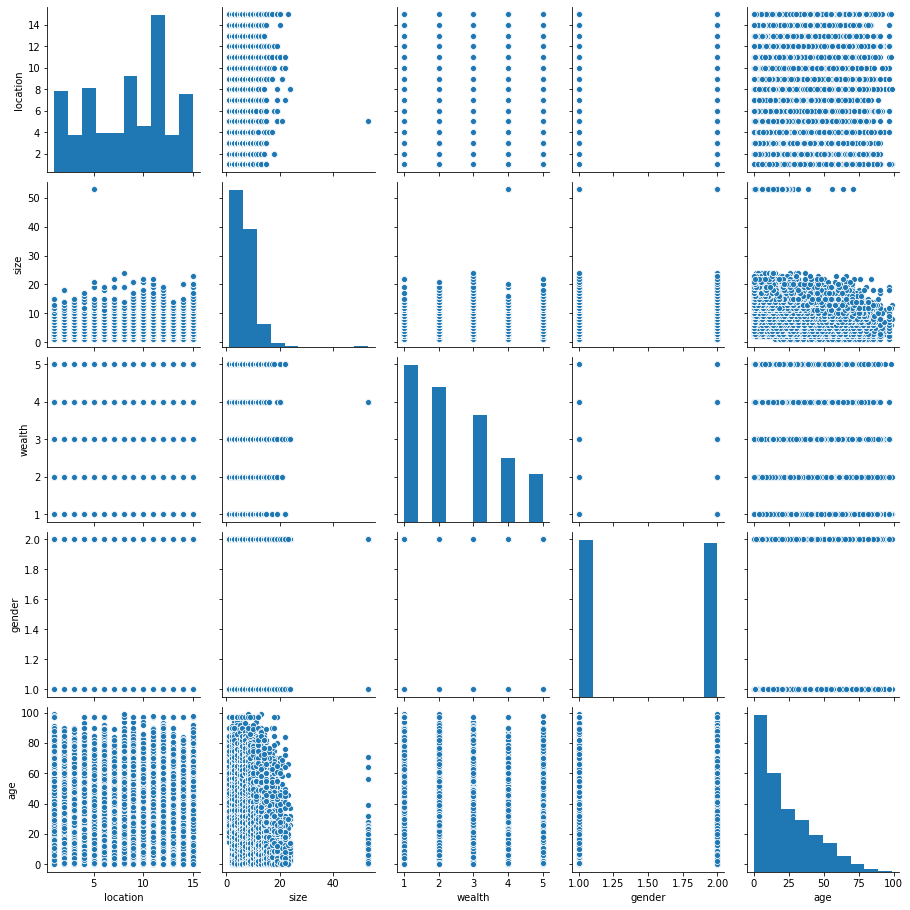

In [189]:
import seaborn as sns
sns.pairplot(X[['location', 'size', 'wealth', 'gender', 'age']])
plt.savefig('pair_plot.png')
plt.show()

In [50]:
#split data into training and testing date
from sklearn.model_selection import train_test_split as tts

In [51]:
Xtrain, Xtest, ytrain, ytest = tts(X,y, test_size=.4, random_state=146)

In [52]:
#fit and train logisitic regression on raw data
lr = LR(random_state=146, max_iter=5000)
lr.fit(Xtrain,ytrain)
y_pred = lr.predict(Xtest)

In [53]:
#create a dictionaries to put all the accuracies in a dictionary 
accuracies = dict()

In [54]:
from sklearn.metrics import accuracy_score
#compute accurarcy of LR on raw data
acc = accuracy_score(ytest,y_pred)
print('Accuracy of LR on Raw tts data: ' + str(acc))
accuracies['Raw'] = acc

Accuracy of LR on Raw tts data: 0.5702509332227291


In [55]:
#Now standardize the dat using minmax ss
from sklearn.preprocessing import MinMaxScaler as MMS

In [56]:
mms = MMS()
Xtrain_mms = mms.fit_transform(Xtrain)
Xtest_mms = mms.transform(Xtest)

In [57]:
#compute accuracy for mms data
lr = LR(random_state=146, max_iter=5000)
lr.fit(Xtrain_mms,ytrain)
y_pred = lr.predict(Xtest_mms)

In [58]:
acc = accuracy_score(ytest,y_pred)
accuracies['MMS']= acc
print('Accuracy of LR on mms: ' + str(acc))

Accuracy of LR on mms: 0.5701990875155537


In [59]:
# use Standard Scaler instead
from sklearn.preprocessing import StandardScaler as SS
ss = SS()
Xtrain_ss = ss.fit_transform(Xtrain)
Xtest_ss = ss.transform(Xtest)

In [60]:
lr = LR(random_state=146, max_iter=5000)
lr.fit(Xtrain_ss,ytrain)
y_pred = lr.predict(Xtest_ss)
acc = accuracy_score(ytest,y_pred)
accuracies['SS']= acc
print('Accuracy of LR on ss: ' + str(acc))

Accuracy of LR on ss: 0.5703027789299046


In [61]:
#Use RobustScaler
from sklearn.preprocessing import RobustScaler as RS
rs = RS()
Xtrain_rs = rs.fit_transform(Xtrain)
Xtest_rs = rs.transform(Xtest)

In [62]:
lr = LR(random_state=146, max_iter=5000)
lr.fit(Xtrain_rs,ytrain)
y_pred = lr.predict(Xtest_rs)
acc = accuracy_score(ytest,y_pred)
accuracies['RS']= acc
print('Accuracy of LR on rs: ' + str(acc))

Accuracy of LR on rs: 0.5701990875155537


In [63]:
#Use Normalizer
from sklearn.preprocessing import Normalizer as NZ
nz = NZ()
Xtrain_nz = rs.fit_transform(Xtrain)
Xtest_nz = rs.transform(Xtest)

In [64]:
lr = LR(random_state=146, max_iter=5000)
lr.fit(Xtrain_nz,ytrain)
y_pred = lr.predict(Xtest_nz)
acc = accuracy_score(ytest,y_pred)
accuracies['NZ']= acc
print('Accuracy of LR on rs: ' + str(acc))

Accuracy of LR on rs: 0.5701990875155537


In [65]:
accuracies

{'Raw': 0.5702509332227291,
 'MMS': 0.5701990875155537,
 'SS': 0.5703027789299046,
 'RS': 0.5701990875155537,
 'NZ': 0.5701990875155537}

In [66]:
max_lracc = max(accuracies.values())
max_lracc

0.5703027789299046

In [70]:
#perform a kfolds validation with LR and Standard Scalar to make sure it is in the norm
lr = LR(random_state=146,max_iter=5000)
ss=SS()
train_scores_ss,test_scores_ss,mse_train_scores_ss,mse_test_ss = DoKFold(lr,X.values,y.values,20, scaler=ss)         


In [75]:
import numpy as np
print('Avg train score on lr_ss: ' + str(np.mean(train_scores_ss)))
print('Avg test score on lr_ss: ' + str(np.mean(test_scores_ss)))

Avg train score on lr_ss: 0.5723579156895722
Avg test score on lr_ss: 0.5722226964586584


In [ ]:
#perform a lr on tsne data for rr

In [76]:
#perform k-fold on raw data
lr = LR(random_state=146,max_iter=5000)
train_scores_raw,test_scores_raw,mse_train_scores_raw,mse_test_raw = DoKFold(lr,X.values,y.values,20) 
print('Avg train score on lr_raw: ' + str(np.mean(train_scores_raw)))
print('Avg test score on lr_raw: ' + str(np.mean(test_scores_raw)))

Avg train score on lr_raw: 0.5723557326647731
Avg test score on lr_raw: 0.5722226878535619


The maximum accuracy for a logisitic regression was reached with the use of Standard scaler. In fact, doing K-fold validation, we see that it has an even heigher training and testing score than any of the accuracies reported for the other cases, including running on raw data


# Perform K-NN model prediction

In [95]:
values, counts = np.unique(ytrain, return_counts = True)

In [96]:
values

array([0, 1, 2, 3, 8, 9])

In [97]:
counts

array([16170,  7212,  4975,   522,     1,    51])

In [101]:
cols = ['location', 'size', 'wealth', 'gender', 'age']

In [125]:
#perfom a K-NN model on raw data, find best k from a range of 0-15
from sklearn.neighbors import KNeighborsClassifier as KNN
k_range = range(1,20)
ktest_raw_scores = dict()
ktrain_raw_scores = dict()
for k in k_range:
    knn = KNN(n_neighbors = k) #, weights='distance'
    knn.fit(Xtrain,ytrain)
    acc_train = knn.score(Xtrain,ytrain)
    ktrain_raw_scores[k]=acc_train
    y_pred = knn.predict(Xtest)
    acc = accuracy_score(ytest,y_pred)
    ktest_raw_scores[k] = acc
##Raw scores to better without inverse weighting


In [132]:
lis_train = []
for val in ktrain_raw_scores.values():
    lis_train.append(val)
lis_test=[]
for val in ktest_raw_scores.values():
    lis_test.append(val)


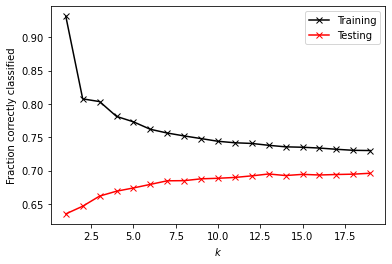

In [133]:
#graph comparison
k_range = np.arange(1, 20, 1)
plt.plot(k_range, lis_train,'-xk', label='Training')
plt.plot(k_range,lis_test,'-xr', label='Testing')
plt.xlabel('$k$')
plt.ylabel('Fraction correctly classified')
plt.legend()
plt.show()
#I would use 6/7 neighbors

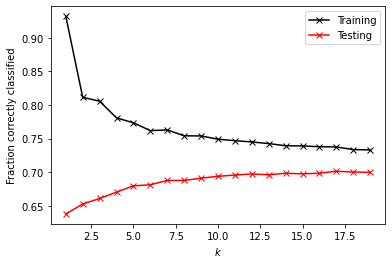

In [139]:
#find best number of neibors for ss
from sklearn.neighbors import KNeighborsClassifier as KNN
k_range = np.arange(1,20,1)
Xtrain_ss = ss.fit_transform(Xtrain)
Xtest_ss = ss.transform(Xtest)
ktrain_ss_scores =[]
ktest_ss_scores = []
for k in k_range:
    knn = KNN(n_neighbors = k) 
    knn.fit(Xtrain_ss,ytrain)
    acc_train = knn.score(Xtrain_ss,ytrain)
    ktrain_ss_scores.append(acc_train)
    y_pred = knn.predict(Xtest_ss)
    acc = accuracy_score(ytest,y_pred)
    ktest_ss_scores.append(acc)

#plot scores    
plt.plot(k_range, ktrain_ss_scores,'-xk', label='Training')
plt.plot(k_range,ktest_ss_scores,'-xr', label='Testing')
plt.xlabel('$k$')
plt.ylabel('Fraction correctly classified')
plt.legend()
plt.show()
#again use 6

In [143]:
print(ktest_ss_scores[6]) #so ss at 6 is better
print(lis_test[6])
print(ktest_mms_scores[6])

0.6876814599751141
0.6847781003732891
0.6961323102447118


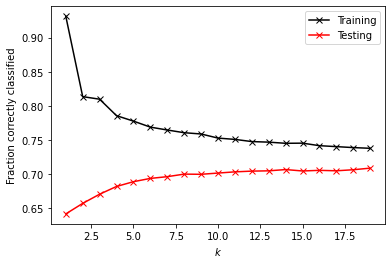

In [190]:
#do same for minmax
k_range = np.arange(1,20,1)
mms = MMS()
Xtrain_mms = mms.fit_transform(Xtrain)
Xtest_mms = mms.transform(Xtest)
ktrain_mms_scores =[]
ktest_mms_scores = []
for k in k_range:
    knn = KNN(n_neighbors = k) 
    knn.fit(Xtrain_mms,ytrain)
    acc_train = knn.score(Xtrain_mms,ytrain)
    ktrain_mms_scores.append(acc_train)
    y_pred = knn.predict(Xtest_mms)
    acc = accuracy_score(ytest,y_pred)
    ktest_mms_scores.append(acc)

#plot scores    
plt.plot(k_range, ktrain_mms_scores,'-xk', label='Training')
plt.plot(k_range,ktest_mms_scores,'-xr', label='Testing')
plt.xlabel('$k$')
plt.ylabel('Fraction correctly classified')
plt.legend()
plt.savefig('KNN_N_Neighbors.png')
plt.show()
#again use 6

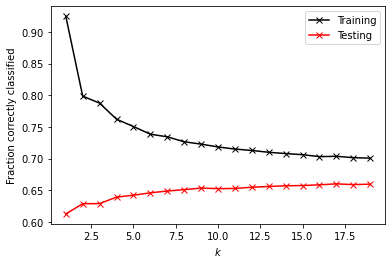

In [144]:
#KNN for Nz
#do same for minmax
k_range = np.arange(1,20,1)
nz = NZ()
Xtrain_nz = nz.fit_transform(Xtrain)
Xtest_nz = nz.transform(Xtest)
ktrain_nz_scores =[]
ktest_nz_scores = []
for k in k_range:
    knn = KNN(n_neighbors = k) 
    knn.fit(Xtrain_nz,ytrain)
    acc_train = knn.score(Xtrain_nz,ytrain)
    ktrain_nz_scores.append(acc_train)
    y_pred = knn.predict(Xtest_nz)
    acc = accuracy_score(ytest,y_pred)
    ktest_nz_scores.append(acc)

#plot scores    
plt.plot(k_range, ktrain_nz_scores,'-xk', label='Training')
plt.plot(k_range,ktest_nz_scores,'-xr', label='Testing')
plt.xlabel('$k$')
plt.ylabel('Fraction correctly classified')
plt.legend()
plt.show()
#again use 6

In [145]:
ktest_nz_scores[6]

0.6488490253007051

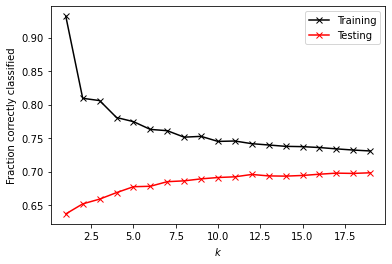

0.6488490253007051

In [146]:
#KNN for RS
k_range = np.arange(1,20,1)
rs = RS()
Xtrain_rs = rs.fit_transform(Xtrain)
Xtest_rs = rs.transform(Xtest)
ktrain_rs_scores =[]
ktest_rs_scores = []
for k in k_range:
    knn = KNN(n_neighbors = k) 
    knn.fit(Xtrain_rs,ytrain)
    acc_train = knn.score(Xtrain_rs,ytrain)
    ktrain_rs_scores.append(acc_train)
    y_pred = knn.predict(Xtest_rs)
    acc = accuracy_score(ytest,y_pred)
    ktest_rs_scores.append(acc)

#plot scores    
plt.plot(k_range, ktrain_rs_scores,'-xk', label='Training')
plt.plot(k_range,ktest_rs_scores,'-xr', label='Testing')
plt.xlabel('$k$')
plt.ylabel('Fraction correctly classified')
plt.legend()
plt.show()
ktest_nz_scores[6]

In [194]:
#perform kfold for n=6 mms to ensure validaty 
knn = KNN(n_neighbors=6)
k_range = np.arange(2,20,1)
mms = MMS()
train_scores_mms_knn,test_scores_mms_knn,mse_train_scores_mms_knn,mse_test_mms_knn = DoKFold(knn,X.values,y.values,20,scaler=mms) 
print('Avg train score on lr_raw: ' + str(np.mean(train_scores_mms_knn)))
print('Avg test score on lr_raw: ' + str(np.mean(test_scores_mms_knn)))
#the average k-fold testing checks out

Avg train score on lr_raw: 0.7697468012474872
Avg test score on lr_raw: 0.6959496068331351


# Decision Trees


In [160]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn import tree

dt_raw_scores = []
d_range = np.arange(1,20, 1)
m_range = np.arange(2,20,1)
for d in d_range:
    for i in m_range:
        params = [d,i]
        dt = DTC(random_state=146, max_depth=d,min_samples_split=i)
        dt.fit(Xtrain,ytrain)
        score = dt.score(Xtest,ytest)
        dt_raw_scores.append([*params,score])
dt_raw_scores

[[1, 2, 0.552675238490253],
 [1, 3, 0.552675238490253],
 [1, 4, 0.552675238490253],
 [1, 5, 0.552675238490253],
 [1, 6, 0.552675238490253],
 [1, 7, 0.552675238490253],
 [1, 8, 0.552675238490253],
 [1, 9, 0.552675238490253],
 [1, 10, 0.552675238490253],
 [1, 11, 0.552675238490253],
 [1, 12, 0.552675238490253],
 [1, 13, 0.552675238490253],
 [1, 14, 0.552675238490253],
 [1, 15, 0.552675238490253],
 [1, 16, 0.552675238490253],
 [1, 17, 0.552675238490253],
 [1, 18, 0.552675238490253],
 [1, 19, 0.552675238490253],
 [2, 2, 0.6281107424305268],
 [2, 3, 0.6281107424305268],
 [2, 4, 0.6281107424305268],
 [2, 5, 0.6281107424305268],
 [2, 6, 0.6281107424305268],
 [2, 7, 0.6281107424305268],
 [2, 8, 0.6281107424305268],
 [2, 9, 0.6281107424305268],
 [2, 10, 0.6281107424305268],
 [2, 11, 0.6281107424305268],
 [2, 12, 0.6281107424305268],
 [2, 13, 0.6281107424305268],
 [2, 14, 0.6281107424305268],
 [2, 15, 0.6281107424305268],
 [2, 16, 0.6281107424305268],
 [2, 17, 0.6281107424305268],
 [2, 18, 0.628

In [159]:
dt = DTC(random_state=146)
dt.fit(Xtrain,ytrain)
dt.score(Xtest,ytest)

0.6419535462463708

In [181]:
dt = DTC(random_state=146, max_depth=9,min_samples_split=18)
dt_train,dt_test,_,_ = DoKFold(dt,X.values,y.values,20)
print(np.mean(dt_train))
print(np.mean(dt_test))

0.7326343295614747
0.7204213743716127


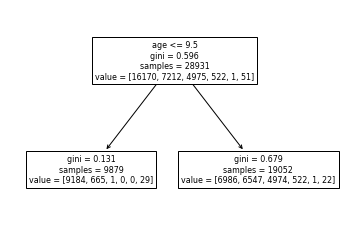

In [171]:
dt = DTC(random_state=146, max_depth=1)
dt.fit(Xtrain,ytrain)
tree.plot_tree(dt,feature_names=list(X.columns));